# Import Libraries

In [6]:
import cv2
from craft_text_detector import Craft
import matplotlib.pyplot as plt
import os
import pytesseract
from skewness import *
import glob
from mmocr.apis import MMOCRInferencer
import numpy as np
import math

# Tesseract

In [3]:
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

os.environ["TESSDATA_PREFIX"] =  "C://Program Files//Tesseract-OCR//tessdata"
custom_config = r'-c preserve_interword_spaces=5 --oem 3 --psm 8'

# Angle Module

In [9]:
class CraftModule:
    def __init__(self,craft):
        self.craft = craft
        self.boxes = None
        self.image = None
    
    def plot_image(self,img):
        plt.axis('off');
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
        plt.show();
            
    def get_bounding_boxes(self,box):
        flat_box = box.flatten()
        x_min = round(min([flat_box[x] for x in [0,2,4,6]]))
        y_min = round(min([flat_box[y] for y in [1,3,5,7]]))
        x_max = round(max([flat_box[x] for x in [0,2,4,6]]))
        y_max = round(max([flat_box[y] for y in [1,3,5,7]]))

        return x_min,y_min,x_max,y_max
    
    def detect_text(self,image):
        self.image = image.copy()
        self.boxes = self.craft.detect_text(self.image)['boxes']
        self.plot_image(self.image)
        print('------------ Detected Text Regions ------------')
        self.draw_rectangles()
        # print('------------ Croped Text Regions ------------')
        self.show_cropped_image()
    
    def draw_rectangles(self):
        image_rect = self.image.copy()
        for box in self.boxes:
            if len(box) >= 3:
                box_points = np.array(box, dtype=np.int32).reshape(-1, 2)
                rotated_rect = cv2.minAreaRect(box_points)
                box_vertices = cv2.boxPoints(rotated_rect)
                box_vertices = np.int0(box_vertices)
                cv2.drawContours(image_rect, [box_vertices], 0, (255, 0, 0), 2)
        self.plot_image(image_rect)
            
    def show_cropped_image(self):
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            roi = self.image[y_min : y_max , x_min : x_max].copy()
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_invert = cv2.bitwise_not(roi_gray)
            thresh = cv2.threshold(roi_gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            edges = cv2.Canny(roi, 27, 255)
            self.plot_image(roi_gray)
            # self.plot_image(cv2.bitwise_not(roi_gray))


            # contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            # print(len(contour))
            
            # text_english_t = pytesseract.image_to_string(thresh,lang = 'eng', config = custom_config)
            # text_nepali_t = pytesseract.image_to_string(thresh,lang = 'nep', config = custom_config)
            # text_nepali_hin_t = pytesseract.image_to_string(thresh,lang = 'nep+hin', config = custom_config)


            text_english = pytesseract.image_to_string(roi_invert,lang = 'eng', config = custom_config)
            text_nepali = pytesseract.image_to_string(roi_invert,lang = 'nep', config = custom_config)
            text_nepali_hin = pytesseract.image_to_string(roi_invert,lang = 'nep+hin', config = custom_config)


            print(f'English (gray) : {text_english}')
            print(f'Nepali (gray) : {text_nepali}')
            print(f'Nepali + Hindi (gray) : {text_nepali_hin}')

            # print(f'English (thresh) : {text_english_t}')
            # print(f'Nepali (thresh) : {text_nepali_t}')
            # print(f'Nepali + Hindi (thresh) : {text_nepali_hin_t}')


            self.plot_image(roi)
    

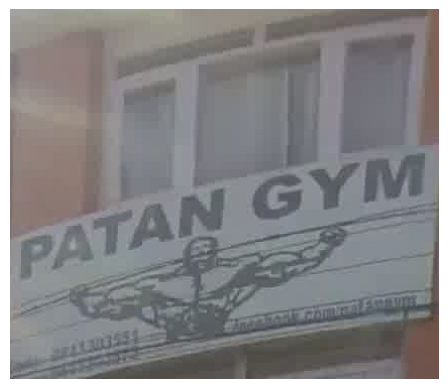

------------ Detected Text Regions ------------


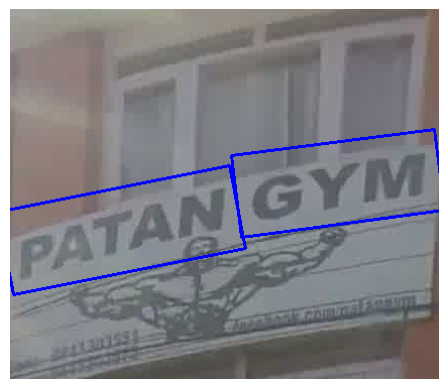

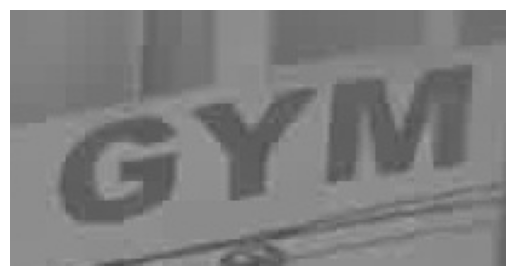

English (gray) : ‘GYM

Nepali (gray) : छा

Nepali + Hindi (gray) : 3201



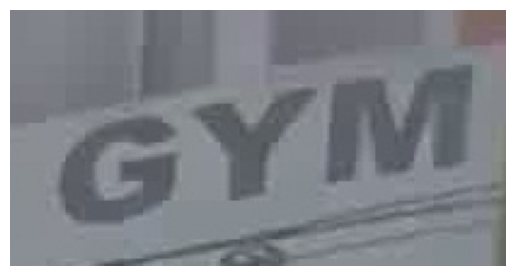

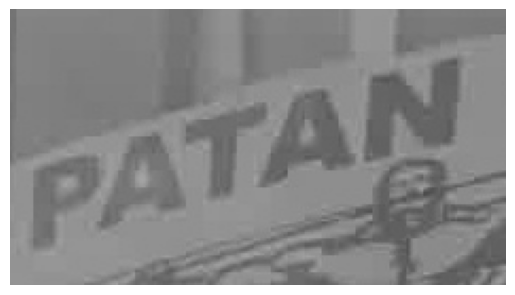

English (gray) : PATAN

Nepali (gray) : हा

Nepali + Hindi (gray) : हा



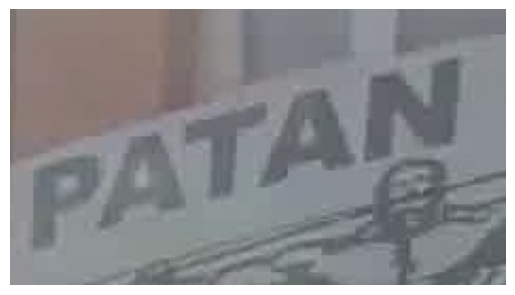

In [11]:
craft = Craft( crop_type="box", cuda=True,text_threshold=0.8,link_threshold=0.8,low_text=0.1)
img = cv2.imread('images/tt.png')
CraftModule(craft).detect_text(img)